In [4]:
import sys
from pathlib import Path
sys.path.append("..")
import pandas as pd
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from simulation.rotor import MagneticBearing3D
from simulation.pid import PID
from simulation.seal import Seal
from simulation.excitation_signals import *
from simulation.generate_dataset import *

In [5]:
import os

data_dir = Path(f"../simulation/data/sin_simple/")

data = []
for file in filter(lambda x: x.endswith(".csv"), os.listdir(data_dir)):
    print(file)
    data.append(pd.read_csv(data_dir / Path(file)))

excitation_x_freq_14Hz_seal_True.csv
excitation_x_freq_19Hz_seal_True.csv
excitation_x_freq_4Hz_seal_True.csv
excitation_x_freq_9Hz_seal_True.csv
excitation_y_freq_14Hz_seal_True.csv
excitation_y_freq_4Hz_seal_True.csv
excitation_y_freq_9Hz_seal_True.csv


In [6]:
_df = data[-1]

_df

,f_ax,f_ay,f_bx,f_by,ax,ay,bx,by,t,fx,fy,y,x,episode
0,0.0,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.0,0.000000,0.000000e+00,0.000000e+00,0
1,0.0,0.005655,0.0,0.005655,0.000000e+00,5.654837e-11,0.000000e+00,5.654837e-11,0.0001,0.0,0.005655,5.654837e-11,0.000000e+00,0
2,0.0,0.011309,0.0,0.011309,-2.431580e-16,2.821440e-10,-2.431580e-16,2.821440e-10,0.0002,0.0,0.011309,2.821440e-10,-2.431580e-16,0
3,0.0,0.016964,0.0,0.016964,-1.940121e-15,7.879803e-10,-1.940121e-15,7.879803e-10,0.0003,0.0,0.016964,7.879803e-10,-1.940121e-15,0
4,0.0,0.022618,0.0,0.022618,-8.220156e-15,1.683834e-09,-8.220156e-15,1.683834e-09,0.0004,0.0,0.022618,1.683834e-09,-8.220156e-15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-0.0,-0.028271,-0.0,-0.028271,4.147008e-06,-6.903345e-05,4.147008e-06,-6.903345e-05,9.9995,-0.0,-0.028271,-6.903345e-05,4.147008e-06,0
99996,-0.0,-0.022618,-0.0,-0.022618,4.126409e-06,-6.835548e-05,4.126409e-06,-6.835548e-05,9.9996,-0.0,-0.022618,-6.835548e-05,4.126409e-06,0
99997,-0.0,-0.016964,-0.0,-0.016964,4.105678e-06,-6.767533e-05,4.105678e-06,-6.767533e-05,9.9997,-0.0,-0.016964,-6.767533e-05,4.105678e-06,0
99998,-0.0,-0.011309,-0.0,-0.011309,4.084815e-06,-6.699301e-05,4.084815e-06,-6.699301e-05,9.9998,-0.0,-0.011309,-6.699301e-05,4.084815e-06,0


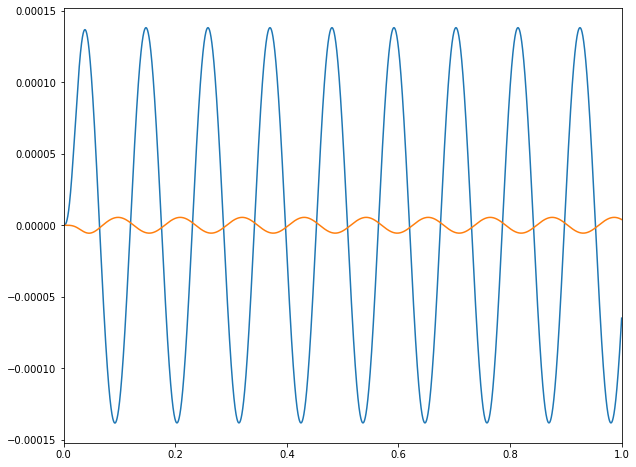

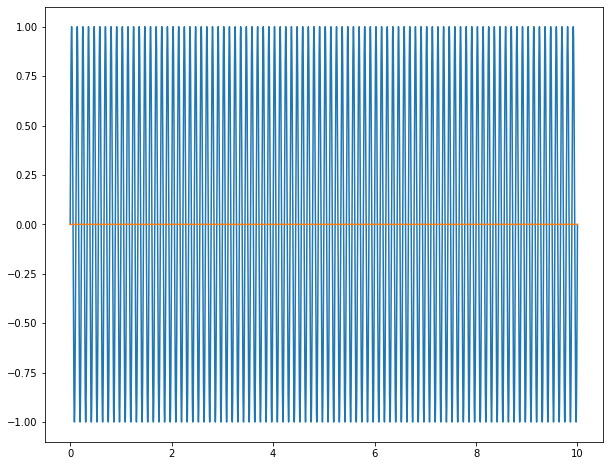

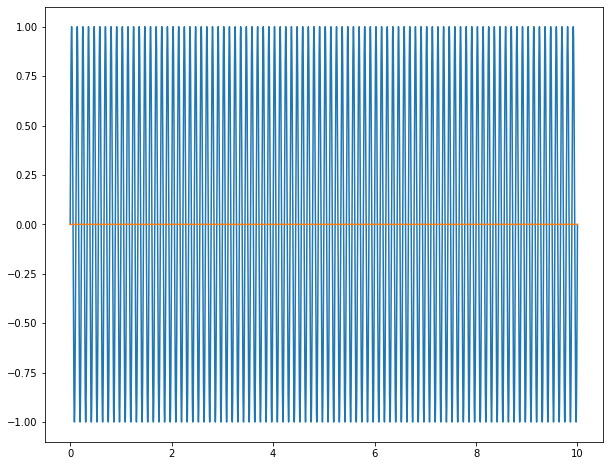

In [9]:
df = _df[_df.episode == 0]
plt.figure(figsize=(10,8))
plt.plot(df["t"], df["ay"])
#plt.plot(df["t"], df["by"])
plt.plot(df["t"], df["ax"])
plt.xlim(0, 1)
plt.show()

plt.figure(figsize=(10,8))
plt.plot(df["t"], df["f_ay"])
plt.plot(df["t"], df["f_ax"])
plt.show()

plt.figure(figsize=(10,8))
plt.plot(df["t"], df["fy"])
plt.plot(df["t"], df["fx"])
plt.show()

In [11]:
from estimators.frequency import EIVSin
from collections import Counter
from numpy.fft import fft, fftshift, fftfreq
%load_ext autoreload
%autoreload 2

In [21]:
f = 9

estimator = EIVSin()

df_x = pd.read_csv(f"../simulation/data/sin_simple/excitation_x_freq_{f}Hz_seal_True.csv")
df_y = pd.read_csv(f"../simulation/data/sin_simple/excitation_y_freq_{f}Hz_seal_True.csv")


ws = estimator.estimate(df_x=df_x,
                        df_y=df_y,
                        freq=f)

ws

44


{'freq': 9,
 'G': array([[10220.64626894+3.41983563e+03j,   431.78830548+1.77210726e-01j],
        [ -421.46341188+1.30535483e+00j,  6350.55071132+3.44245183e+03j]]),
 'C': array([[6.04759718e+01, 3.13377367e-03],
        [2.30837416e-02, 6.08759140e+01]]),
 'K': array([[13418.39809489,   431.78830548],
        [ -421.46341188,  9548.30253728]])}

In [22]:

estimator = EIVSin()

df_x = pd.read_csv(f"../simulation/data/sin_simple/excitation_x_freq_{f}Hz_seal_False.csv")
df_y = pd.read_csv(f"../simulation/data/sin_simple/excitation_y_freq_{f}Hz_seal_False.csv")


wos = estimator.estimate(df_x=df_x,
                        df_y=df_y,
                        freq=f)

wos

44


{'freq': 9,
 'G': array([[5.90863057e+03+1007.91741009j, 1.86366249e+00  +10.38481002j],
        [1.86366249e+00  +10.38481002j, 5.90863057e+03+1007.91741009j]]),
 'C': array([[17.82389312,  0.18364376],
        [ 0.18364376, 17.82389312]]),
 'K': array([[9.10638240e+03, 1.86366249e+00],
        [1.86366249e+00, 9.10638240e+03]])}

In [23]:
ws["K"] - wos["K"]

array([[4312.01569675,  429.92464299],
       [-423.32707437,  441.92013914]])

In [24]:
ws["C"] - wos["C"]

array([[42.65207864, -0.18050999],
       [-0.16056002, 43.05202086]])

In [13]:
if False:
    freq = 4
    dt = (df_x["t"] - df_y["t"].shift()).median()

    dfs = []
    for episode, group in df_x.groupby("episode"):
        temp = estimator.get_frequency_domain_data(df=group,
                                              freq=freq,
                                              dt=dt)
        temp["episode"] = episode
        dfs.append(temp)
    df_x = pd.concat(dfs, ignore_index=True)

    dfs = []
    for episode, group in df_y.groupby("episode"):
        temp = estimator.get_frequency_domain_data(df=group,
                                              freq=freq,
                                              dt=dt)
        temp["episode"] = episode
        dfs.append(temp)
    df_y = pd.concat(dfs, ignore_index=True)


    print(df_x.columns)
    print(df_y.columns)

    df = pd.concat([df_x, df_y], ignore_index=False)

    # Apenas frequencia de interesse
    sel_df = df[(df["freqs"] > freq - 2) & (df["freqs"] < freq + 1)].sort_index()
    # Apenas indices que exisitam no dataframe x e y
    inds = list(map(lambda x: x[0], (filter(lambda x: x[1] == 2, Counter(df.index).most_common()))))


    inds = list(filter(lambda  x: x in sel_df.index, inds))

    print(len(inds))
    sel_df = sel_df.loc[inds]
    sel_df
    
    Us = []
    Ys = []
    for name, group in sel_df.groupby(sel_df.index):
        U = group[["xf", "yf"]].values.transpose()
        Y = group[["fxf", "fyf"]].values.transpose()
        Us.append(U)
        Ys.append(Y)
    Us = np.array(Us)
    Ys = np.array(Ys)

    G = np.mean(Ys, axis=0) @ np.linalg.inv(np.mean(Us, axis=0))
    C = np.imag(G) / (2 * np.pi * freq)
    K = np.real(G) + (2 * np.pi * freq) ** 2 * np.array([[1, 0], [0, 1]])
    print(C, K)
    
    df = dfs[0]
    plt.scatter(df["freqs"], np.abs(df["fyf"]), s=1)
    plt.xlim((-10, 10))
    plt.show()

    plt.scatter(df["freqs"], np.abs(df["yf"]), s=1)
    plt.xlim((-35, 35))
    plt.show()

In [62]:
ws["K"] - wos["K"]

NameError: name 'wos' is not defined

In [23]:
freq = 9

dt = (df_x["t"] - df_y["t"].shift()).median()

df_x = estimator.get_frequency_domain_data(df=df_x,
                                      freq=freq,
                                      dt=dt)

df_y = estimator.get_frequency_domain_data(df=df_y,
                                      freq=freq,
                                      dt=dt)

df = pd.concat([df_x, df_y], ignore_index=False)

# Apenas frequencia de interesse
sel_df = df[(df["freqs"] > freq - 2) & (df["freqs"] < freq + 1)].sort_index()
# Apenas indices que exisitam no dataframe x e y
inds = list(map(lambda x: x[0], (filter(lambda x: x[1] == 2, Counter(sel_df.index).most_common()))))



inds = list(filter(lambda  x: x in sel_df.index, inds))

print(len(inds))
sel_df = sel_df.loc[inds]

KeyError: 't'

In [ ]:
Us = []
Ys = []
for name, group in sel_df.groupby(sel_df.index):
    U = group[["xf", "yf"]].values.transpose()
    Y = group[["fxf", "fyf"]].values.transpose()
    Us.append(U)
    Ys.append(Y)
Us = np.array(Us)
Ys = np.array(Ys)

G = np.mean(Ys, axis=0) @ np.linalg.inv(np.mean(Us, axis=0))
C = np.imag(G) / (2 * np.pi * freq)
K = np.real(G) + (2 * np.pi * freq) ** 2 * np.array([[1, 0], [0, 1]])